#### 1. Install dependencies and setup

In [1]:
%pip install tensorflow opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# gpus = tf.config.experimental.list_physical_devices('GPU')

# for gpu in gpus: 
#     tf.config.experimental.set_memory_growth(gpu, True)

##### 1.2 Load data

In [4]:
# data = tf.keras.utils.image_dataset_from_directory("../processedDataSetAds/train")
from get_dataset import DataSetLoader

data_dirs = ["C:\\Users\\daniel2.DESKTOP-ARTCORE\\Documents\\AdVision\\adblocker\\pyton\\processedDataSetAds\\0", "C:\\Users\\daniel2.DESKTOP-ARTCORE\\Documents\\AdVision\\adblocker\\pyton\\processedDataSetAds\\1"]

dataset_loader = DataSetLoader()
datasets = []
for dir in data_dirs:
    datasets.append(dataset_loader.load(dir, label=os.path.basename(dir)))

full_dataset = datasets[0]
for dataset in datasets[0:]:
    full_dataset = full_dataset.concatenate(dataset)

shuffled_dataset = full_dataset.shuffle(buffer_size=1024)

Getting images from C:\Users\daniel2.DESKTOP-ARTCORE\Documents\AdVision\adblocker\pyton\processedDataSetAds\0\nested\evenmore\againnested\morenesting
Found 70 files belonging to 1 classes.
Getting images from C:\Users\daniel2.DESKTOP-ARTCORE\Documents\AdVision\adblocker\pyton\processedDataSetAds\1\evenmore\hello\morenesting
Found 70 files belonging to 1 classes.


In [5]:
iterator = shuffled_dataset.as_numpy_iterator()

In [6]:
try:
    batch = iterator.next()
except StopIteration:
    print("Reached the end of the dataset")


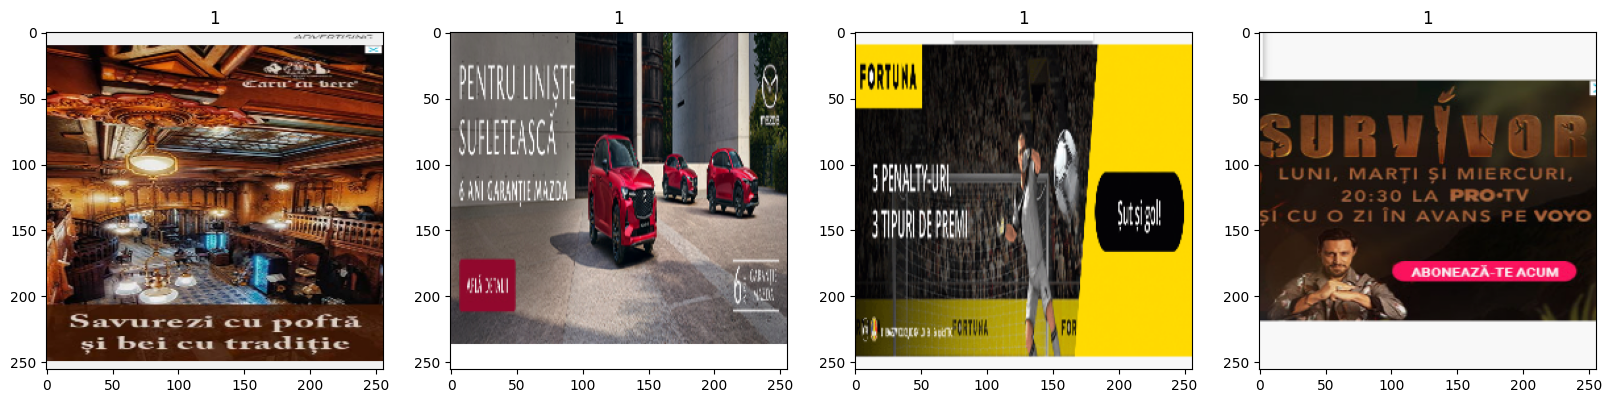

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

As we can see the labels will be: 
- 1 for Non Ad
- 0 for Ad

#### 2. Preprocessing

##### 2.1 Scale Data

In [8]:
normalized_data = shuffled_dataset.map(lambda x, y: (x/255, y))

Check if data is normalized between 0 and 1 

In [9]:
normalized_data.as_numpy_iterator().next()[0].max()

1.0

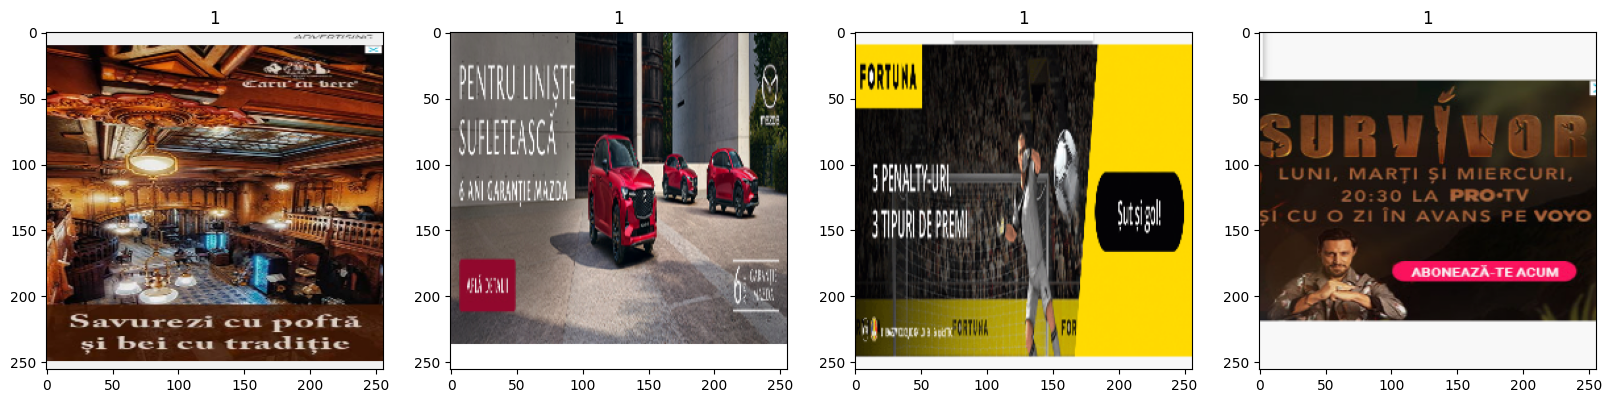

In [10]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

##### 2.2 Split Data 

Checking the length of our data in number of batches

In [11]:
len(normalized_data)

9

In [12]:
train_size = int(len(normalized_data)*.7)
val_size = int(len(normalized_data)*.2)+1
test_size = int(len(normalized_data)*.1)+1

In [13]:
train = normalized_data.take(train_size)
val = normalized_data.skip(train_size).take(val_size)
test = normalized_data.skip(train_size+val_size).take(test_size)

In [14]:
len(test)

1

#### 3. Deep Model

##### 3.1 Build the model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [16]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

##### 3.2 Train

In [18]:
logdir='logs'

In [19]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [20]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
6/6 [==============================] - 3s 371ms/step - loss: 1.1871 - accuracy: 0.6857 - val_loss: 0.2509 - val_accuracy: 1.0000
Epoch 2/20
6/6 [==============================] - 2s 408ms/step - loss: 0.5999 - accuracy: 0.8072 - val_loss: 0.6904 - val_accuracy: 0.5000
Epoch 3/20
6/6 [==============================] - 2s 342ms/step - loss: 0.6750 - accuracy: 0.7286 - val_loss: 0.6248 - val_accuracy: 1.0000
Epoch 4/20
6/6 [==============================] - 3s 498ms/step - loss: 0.7972 - accuracy: 0.8072 - val_loss: 0.9602 - val_accuracy: 0.5000
Epoch 5/20
6/6 [==============================] - 2s 386ms/step - loss: 0.6915 - accuracy: 0.6667 - val_loss: 0.9007 - val_accuracy: 0.0000e+00
Epoch 6/20
6/6 [==============================] - 2s 287ms/step - loss: 0.6536 - accuracy: 0.6667 - val_loss: 0.7149 - val_accuracy: 0.5000
Epoch 7/20
6/6 [==============================] - 2s 360ms/step - loss: 0.6371 - accuracy: 0.7286 - val_loss: 0.4700 - val_accuracy: 1.0000
Epoch 8/20
6/6 [

3.3 Plot Performance

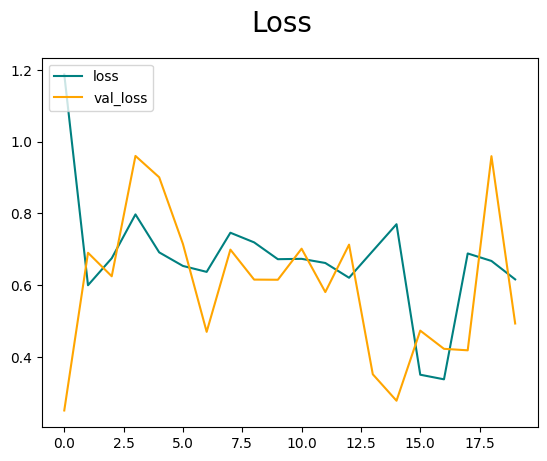

In [21]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

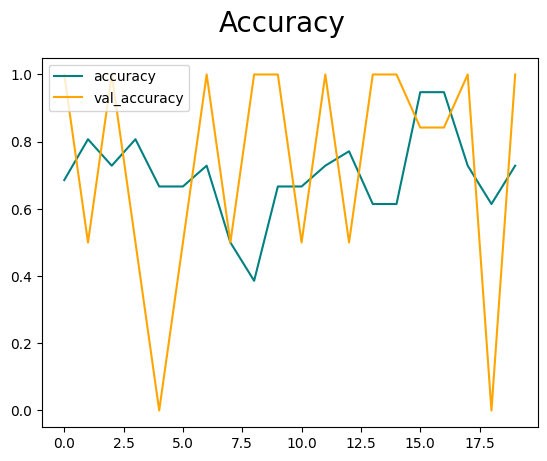

In [22]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

#### 4. Evaluate Performance

4.1 Evaluate

In [23]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [24]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [25]:
len(test)

1

In [26]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 135ms/step


In [27]:
print(f'Precision: {precision.result().numpy()}, Recall: {recall.result().numpy()}, Accuracy: {accuracy.result().numpy()}')

Precision: 0.0, Recall: 0.0, Accuracy: 1.0


4.2 Test

In [28]:
import cv2
img = cv2.imread('/mnt/c/Users/daniel2.DESKTOP-ARTCORE/Documents/AdVision/adblocker/pyton/processedDataSetAds/ex_image.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [ ]:
resized_image = tf.image.resize(img, (256, 256))
plt.imshow(resized_image.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resized_image/255, 0))

In [ ]:
if yhat < 0.5: 
    print(f'With a confidence of {int((abs(yhat-1)*100)[0][0])}%')
    print(f'The image is AD')
else: 
    print(f'With a confidence of {int((yhat*100)[0][0])}%')
    print(f'The image is NOT AD')


Let's test it with a non-AD

In [ ]:
import cv2
img_non_ad = cv2.imread('/mnt/c/Users/daniel2.DESKTOP-ARTCORE/Documents/AdVision/adblocker/pyton/processedDataSetAds/non_ad.jpg')
resized_nonad = tf.image.resize(img_non_ad, (256, 256))
plt.imshow(resized_nonad.numpy().astype(int))

In [ ]:
yhat = model.predict(np.expand_dims(resized_nonad/255, 0))

In [ ]:
if yhat < 0.5: 
    print(f'With a confidence of {int((abs(yhat-1)*100)[0][0])}%')
    print(f'The image is AD')
else: 
    print(f'With a confidence of {int((yhat*100)[0][0])}%')
    print(f'The image is NOT AD')


#### 5. Save the Model

##### 5.1 Save and Load the Model

In [ ]:
from tensorflow.keras.models import load_model
model.save(os.path.join('models', 'adnonadmodel.h5'))
new_model = load_model(os.path.join('models', 'adnonadmodel.h5'))

In [ ]:

yhat_new = new_model.predict(np.expand_dims(resized_nonad/255, 0))

In [ ]:
if yhat_new < 0.5: 
    print(f'With a confidence of {int((abs(yhat_new-1)*100)[0][0])}percent')
    print(f'The image is AD')
else: 
    print(f'With a confidence of {int((yhat_new*100)[0][0])}percent')
    print(f'The image is NOT AD')

In [ ]:
!tensorflowjs_converter --input_format=keras /mnt/c/Users/daniel2.DESKTOP-ARTCORE/Documents/AdVision/adblocker/pyton/jupyter/models/adnonadmodel.h5 /mnt/c/Users/daniel2.DESKTOP-ARTCORE/Documents/AdVision/adblocker/pyton/jupyter/models/tfjs_model